In [ ]:
#checking we are working on the right virtual environment

In [1]:
import sys
sys.executable
#!pip3 freeze > requirements.txt
#!python --version

'/Users/federicojacopobaldoni/Documents/LUISS/machine_learning/pino_env/bin/python3'

# IMPORT PACKAGES

In [2]:
import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import spearmanr

from sklearn.model_selection import StratifiedShuffleSplit
from math import log2

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from yellowbrick.regressor import PredictionError, ResidualsPlot
import shap #numba provides some warnings

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures

from joblib import dump, load

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

/Users/federicojacopobaldoni/Documents/LUISS/machine_learning/pino_env/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/federicojacopobaldoni/Documents/LUISS/machine_learning/pino_env/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/Users/federicojacopobaldoni/Document

# DEFING SOME USEFUL FUNCTIONS

In [3]:
def visualizer():
    viz = PredictionError(model, bestfit=False, alpha=0.2) #it gives problems with bestfit=True
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    scatter_kwargs = {'color': (222/255, 151/255, 228/255)}
    viz.show(bgcolor='k', scatter_kwargs=scatter_kwargs)
    #with ResidualsPlot sometimes kernel dies
    #viz = ResidualsPlot(model, test_alpha=0.1) #, hist=False, qqplot=True
    #viz.fit(X_train, y_train)
    #viz.score(X_test, y_test)
    #viz.show()
    
def visualizer_ct():
    viz = PredictionError(model, bestfit=False, alpha=0.2) #it gives problems with bestfit=True
    viz.fit(X_train_ct, y_train)
    viz.score(X_test_ct, y_test)
    scatter_kwargs = {'color': (222/255, 151/255, 228/255)}
    viz.show(bgcolor='k', scatter_kwargs=scatter_kwargs)

In [4]:
def metrics():
    print('R2:')
    print('train', r2_score(y_train, model.predict(X_train)))
    print('test:', r2_score(y_test, model.predict(X_test)))
    print('\n')
    print('RMSE')
    print('train', np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print('test:', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print('\n')
    print('MAPE:')
    print('train', mean_absolute_percentage_error(y_train, model.predict(X_train))) #Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2.
    print('test:', mean_absolute_percentage_error(y_test, model.predict(X_test))) #Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2.
    print('\n')
    
def metrics_ct():
    print('R2:')
    print('train', r2_score(y_train, model.predict(X_train_ct)))
    print('test:', r2_score(y_test, model.predict(X_test_ct)))
    print('\n')
    print('RMSE')
    print('train', np.sqrt(mean_squared_error(y_train, model.predict(X_train_ct))))
    print('test:', np.sqrt(mean_squared_error(y_test, model.predict(X_test_ct))))
    print('\n')
    print('MAPE:')
    print('train', mean_absolute_percentage_error(y_train, model.predict(X_train_ct))) #Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2.
    print('test:', mean_absolute_percentage_error(y_test, model.predict(X_test_ct))) #Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2.
    print('\n')

# IMPORT DATASET

In [5]:
df = pd.read_csv('./Project datasets-20230327/flight_dataset.csv', index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


resetting index, just to be sure

In [6]:
df.reset_index(inplace=True, drop=True)

# EDA

In [ ]:
#profile = ProfileReport(df, title="FLIGHTS - Pandas Profiling Report", explorative=True)
#profile.to_file("flights.html")

checking for nans

In [ ]:
df.shape

In [ ]:
df.isna().sum()

checking for duplicates

In [ ]:
df.duplicated().sum()

In [ ]:
df.describe()

In [ ]:
########
########

## PRICE

looking at price distribution

In [ ]:
fig, axs = plt.subplots(figsize=(12,10))
sns.histplot(data=df, x='price', kde=True, color='purple')
plt.title('PRICE HISTOGRAM')

price seems to be pretty skewed

we'll probably have to work on it later

In [ ]:
fig, axs = plt.subplots(figsize=(12,10), dpi=300)
sns.boxplot(data=df, x='price', color='violet')
plt.title('PRICE BOXPLOT')

In [ ]:
#########
########

### CITIES

price boxplots on source and destionation cities

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

g1 = sns.boxplot(data=df, x='price', y='source_city', ax=axs[0])
g1.set(title = 'BOXPLOT PRICE - SOURCE CITY')

g2 = sns.boxplot(data=df, x='price', y='destination_city', ax=axs[1])
g2.set(title = 'BOXPLOT PRICE - DESTINATION CITY')

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

g1 = sns.histplot(data=df, x='price', hue='source_city', kde=True, ax=axs[0])
g1.set(title = 'COUNTPLOT & KDES PRICE - SOURCE CITY')

g2 = sns.histplot(data=df, x='price', hue='destination_city', kde=True, ax=axs[1])
g2.set(title = 'COUNTPLOT & KDES PRICE - DESTINATION CITY')

Indipendently from source or destination city, more economy flights are sold than business flights

In [ ]:
city_cross = pd.crosstab(df['source_city'], df['destination_city'])
city_cross

In [ ]:
for i in city_cross.columns:
    city_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS ARRIVE AT {i}')
    plt.show()

In [ ]:
########
########

### STOPS

price boxplots on the number of stops made

In [ ]:
plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='price', y='stops')
plt.title('BOXPLOT PRICE - STOPS')

interestingly zero stops flights tend to be the more economic ones, this may be due to the fact that they make smaller voyages


two or more stops have a lot of outliers, may that be last minute flights?

In [ ]:
plt.subplots(figsize=(12,5))
sns.histplot(data=df, x='price', hue='stops', kde=True)
plt.title('COUNTPLOT & KDES PRICE - STOPS')

two or more stops flights are the least sold.

one stop flights sell a lot more than the other two categories and sell for both economy and business trips.

zero stops flights sell mostly economy flights

In [ ]:
stops_cross = pd.crosstab(df['destination_city'], df['stops'])
stops_cross

In [ ]:
for i in stops_cross.columns:
    stops_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS {i} STOP')
    plt.show()

Dheli doen't work a lot with two or more stops flights, but works a lot more than the others with zero stop fligths

In [ ]:
#########
#########

### ARRIVAL TIME

price boxplots on the arrival time

In [ ]:
plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x='price', y='arrival_time')
plt.title('BOXPLOT PRICE - ARRIVAL TIME')

as expected the most economic flights are the one that arrive at destination in the late night or early in the morining

also afternoon flights is reasonable that are a little cheaper than the reaming arrival time

In [ ]:
plt.subplots(figsize=(12,5))
sns.histplot(data=df, x='price', hue='arrival_time', kde=True)
plt.title('COUNTPLOT & KDES PRICE - ARRIVAL TIME')

most of tickets is sold at a low price. Tickets indeferently from the arrival_time, except for early_morning flights, seems to have a little peak at 40.000-60.000 price. That's probably due to business flights sales, while the first peak is for economy sales

In [ ]:
arr_cross = pd.crosstab(df['destination_city'], df['arrival_time'])
arr_cross

In [ ]:
for i in arr_cross.columns:
    arr_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS IN THE {i} ')
    plt.show()

it's interesting to notice that Dheli seems to work a lot in the Late_Night, but pretty much nothing in the Early_Morning

In [ ]:
########
########

### CLASS

price boxplots on class

In [ ]:
plt.subplots(figsize=(12,5), dpi=300)
sns.boxplot(data=df, x='price', y='class')
plt.title('BOXPLOT PRICE - CLASS')

well.. as exepcted economy flights are cheaper

plotting countplot and kdes for economy price and business price

In [ ]:
plt.subplots(figsize=(12,5), dpi=300)
sns.histplot(data=df, x='price', hue='class', kde=True)
plt.title('COUNTPLOT & KDES PRICE - CLASS')

business pricess seems to be pretty much Normally distriubuted, but we can't say the same for economy prices

In [ ]:
########
########

### DURATION

price - duration scatterplot

In [ ]:
sns.scatterplot(data=df, x='price', y='duration')
plt.title('SCATTERPLOT PRICE - DURATION')

paradoxaly longer duration flights are not the more expensive

In [ ]:
#########
#########

## CORRELATION

correlation matrix

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

linear correlation is really low, so we expect that linear models won't perform that good.

we still try to predict with a linear model, and then we will compare it's error metric with the one of the other models

Spearman correlation coefficient for categorical variables

In [ ]:
df_cat = df.copy()
for i in df_cat.columns:
    if df_cat[i].dtypes == 'int64' or df_cat[i].dtypes == 'float64':       
           df_cat = df_cat.drop(i, axis=1)
            
for i in df_cat.columns:
    df_cat[i] = df_cat[i].astype('category')

print('Spearman correlation coefficient: \n')
for col1, col2 in combinations(df_cat.columns, 2):
    correlation, p_value = spearmanr(df_cat[col1].cat.codes, df_cat[col2].cat.codes)
    print(col1, '-', col2, ': ', correlation)

In [ ]:
#############
#############

# PRE-PROCESSING

we've already seen that there are non missing values and no duplicates, so we will look for outliers

## OUTLIER DETECTION WITH BOXPLOTS

Text(0.5, 1.0, 'PRICE BOXPLOT')

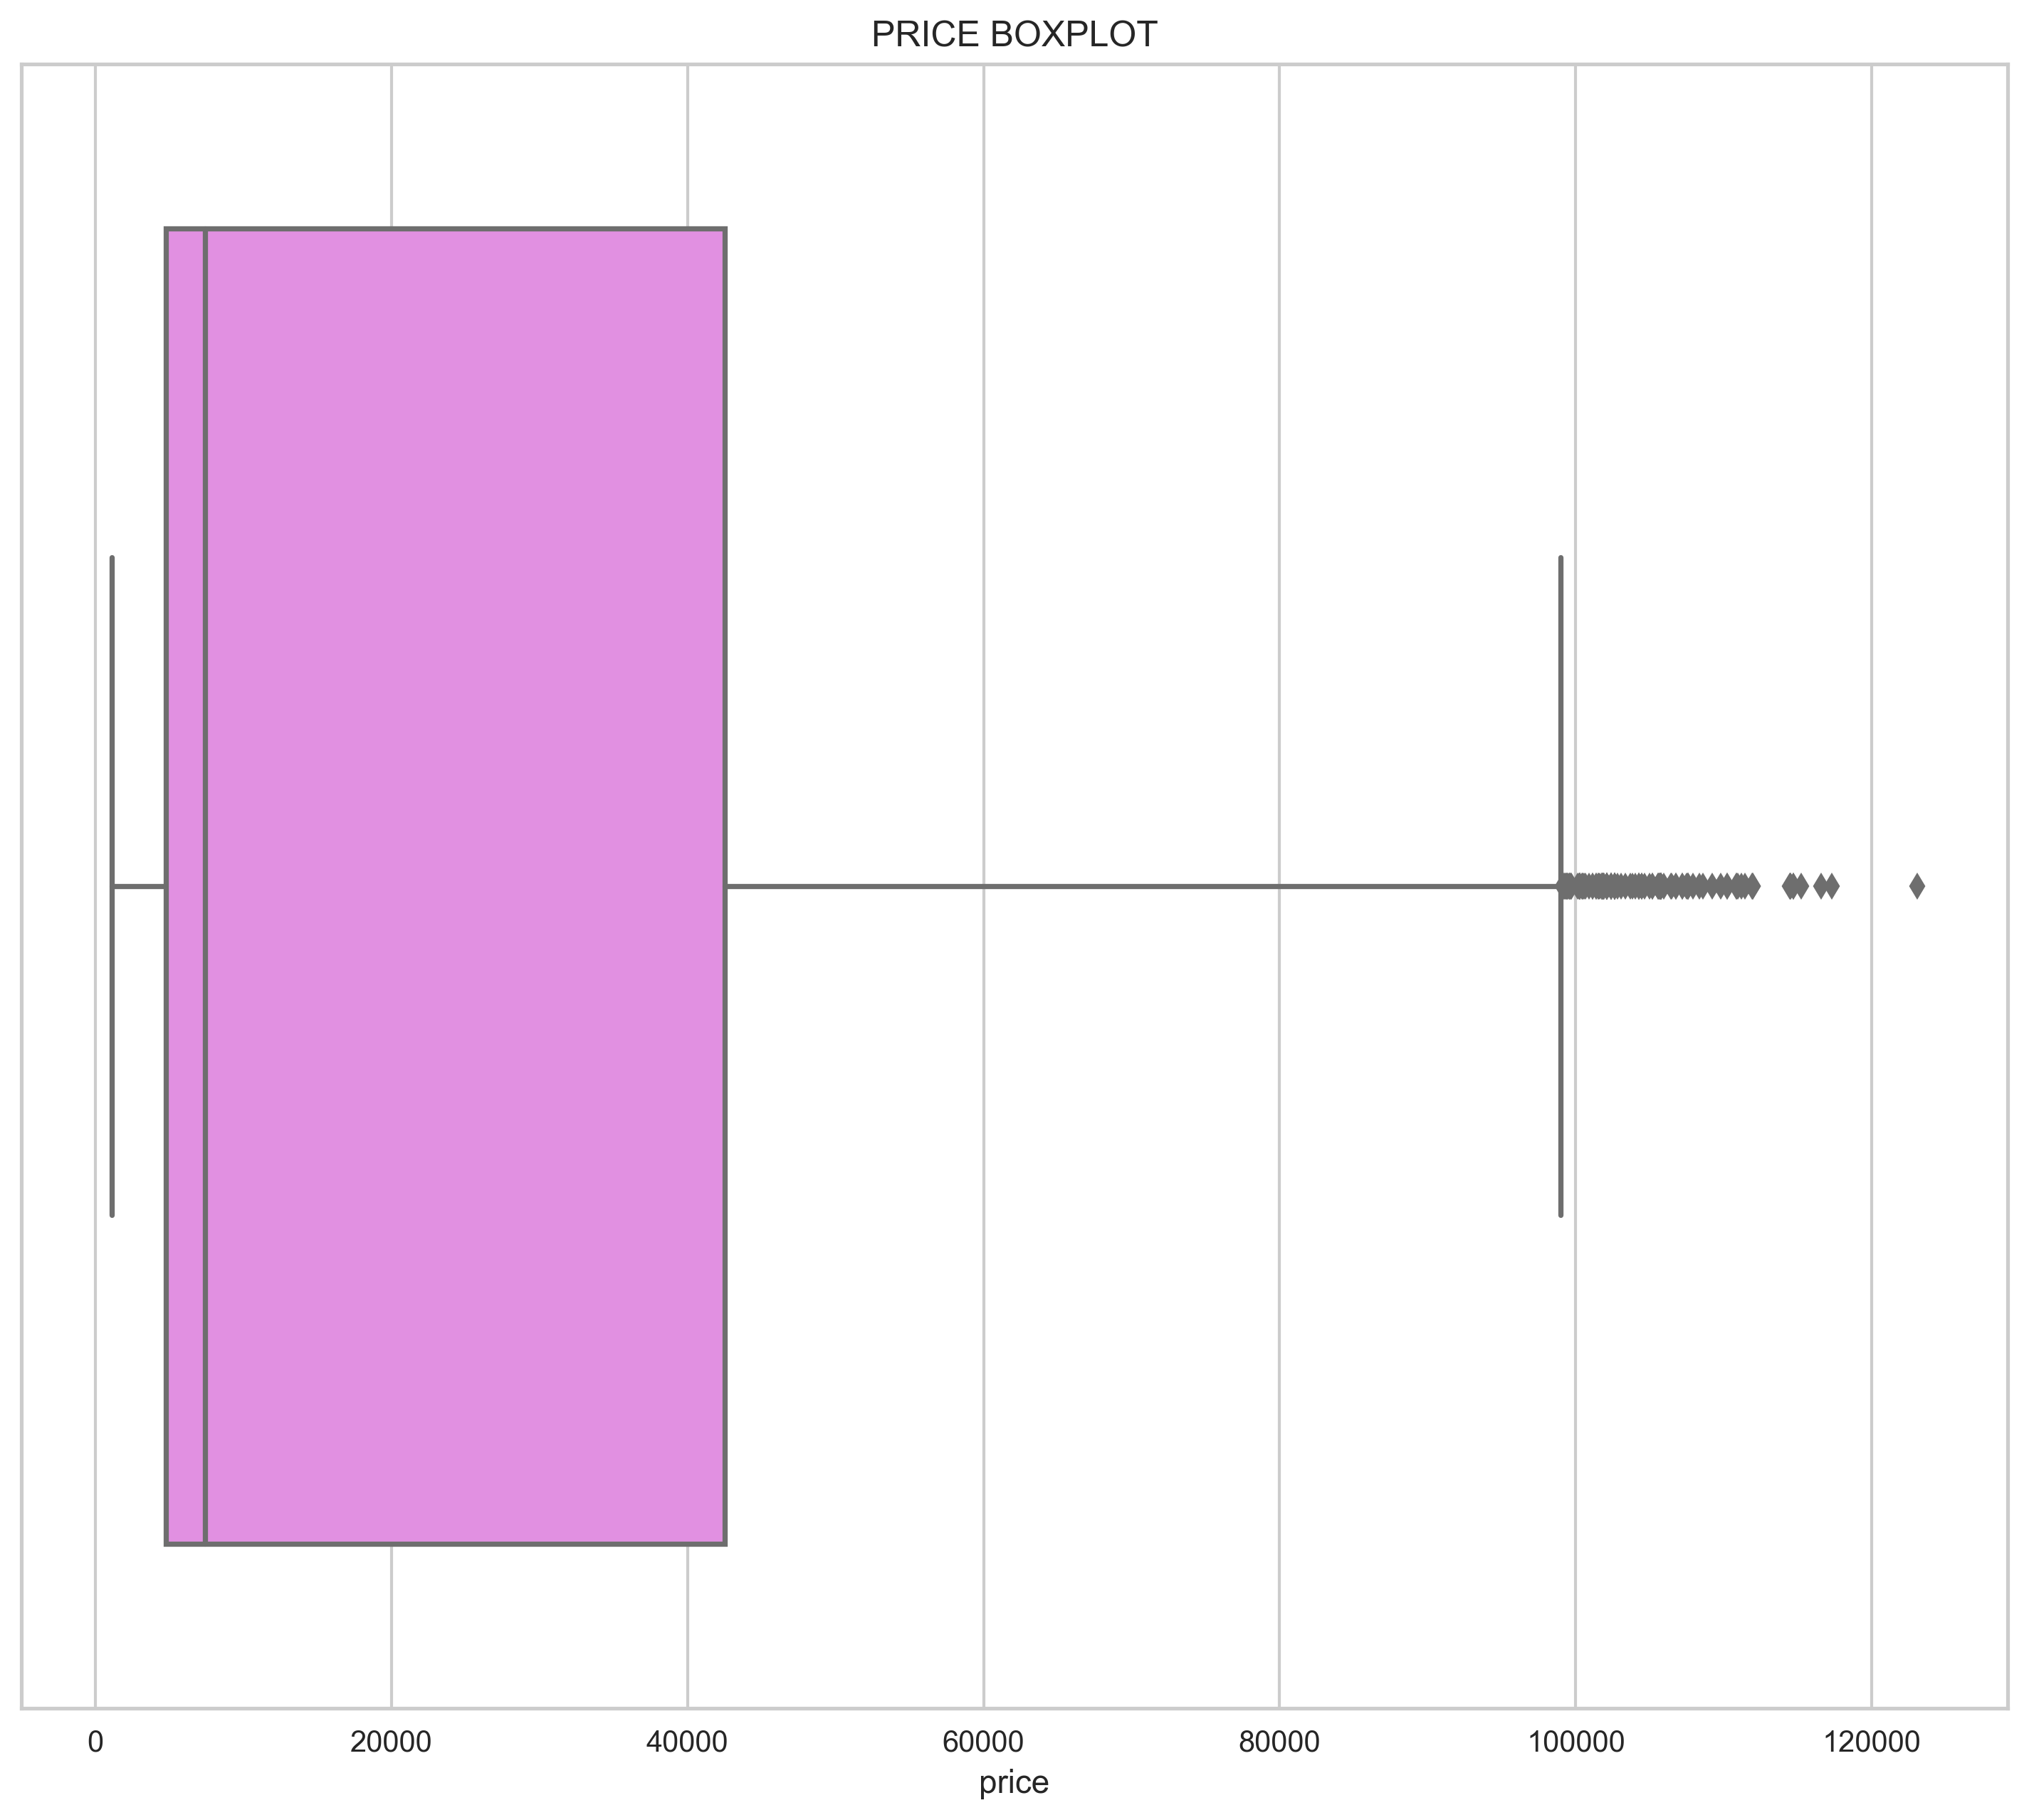

In [7]:
fig, axs = plt.subplots(figsize=(12,10), dpi=300)
sns.boxplot(data=df, x='price', color='violet')
plt.title('PRICE BOXPLOT')

calculating interquantile range and conisdering outlier each observation that is over the treshold of +/-1.5*IQR

In [8]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

out = df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)]
print(len(out), 'outliers were found')

123 outliers were found


removing outliers from the original df and definig a new one

In [9]:
not_out = df.loc[~df.index.isin(out.index)]
not_out.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [10]:
#subsets make sense
not_out.shape[0]+out.shape[0] == df.shape[0]

True

Text(0.5, 1.0, 'PRICE BOXPLOT - NO OUTLIERS')

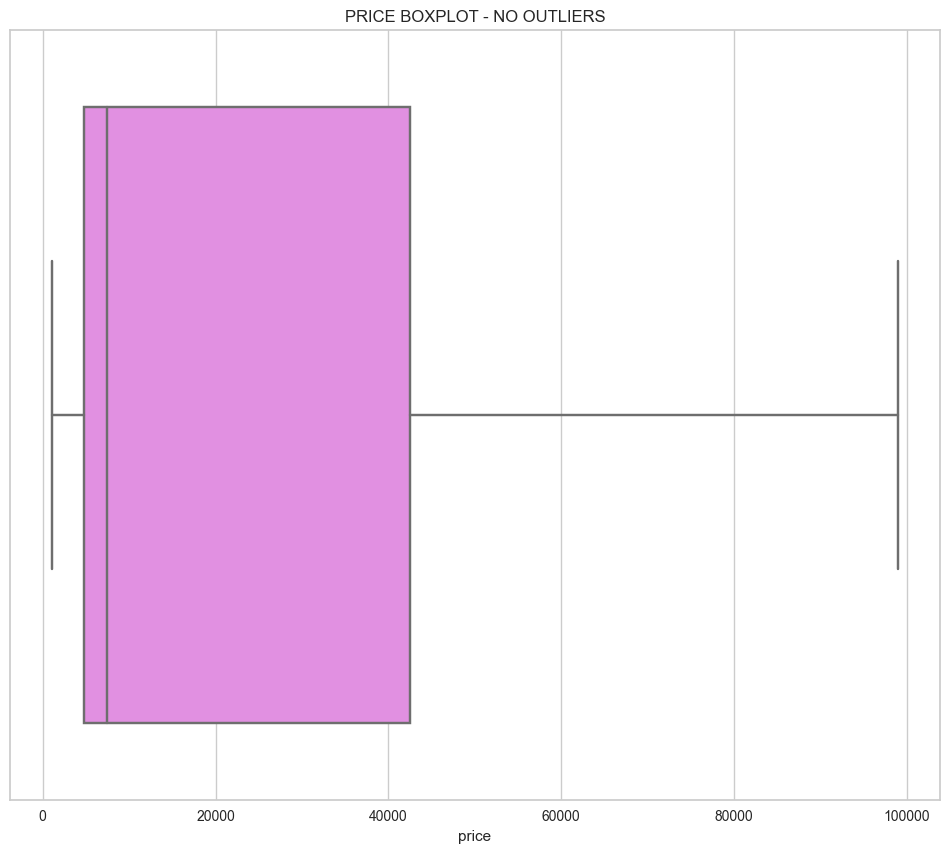

In [11]:
fig, axs = plt.subplots(figsize=(12,10))
sns.boxplot(data=not_out, x='price', color='violet')
plt.title('PRICE BOXPLOT - NO OUTLIERS')

we subscribe the original df with our new df without outliers

In [12]:
df = not_out.copy()

In [13]:
##########
##########

## STRATIFIED TRAIN-TEST SPLIT

In [14]:
#code was inspired by asking to chatgpt:
#"do you how can i make a stratified train test split for a regression problem?"

### LOOKING FOR THE RIGHT NUMBER OF BINS

now we look for the right number of bins to make our stratified train-test split

In [ ]:
#aggiungere titoli ai grafici

In [ ]:
#square-root rule
sns.histplot(data=df, x='price', bins=round(np.sqrt(df.shape[0])))
plt.title('BINS WITH SQUARE-ROOT RULE')

In [ ]:
#Sturges' rule
plt.subplots(figsize=(12,10), dpi=300)
sns.histplot(data=df, x='price', bins=round(1+log2(df.shape[0])))
plt.title('BINS WITH STURGES\' RULE')

In [ ]:
#Freedman-Diaconis' rule

#we removed some observatioms, so we have to calculate again the IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

sns.histplot(data=df, x='price', bins=round((2*IQR)/(df.shape[0]**(1/3))))
plt.title('BINS WITH FREEDMAN-DIACONIS\' RULE')

In [ ]:
#Scott's rule
sns.histplot(data=df, x='price', bins=round((3.5*np.std(df['price']))/(df.shape[0]**(1/3))))
plt.title('BINS WITH SCOTT\'S RULE')

Sturges' rule seems to make not too many bins and not too few bins

### ACTUALLY TRAIN-TEST SPLITTING

In [15]:
# create bins for the target variable
bins = pd.qcut(df['price'], q=round(1+log2(df.shape[0])), labels=False)

# create a stratified train-test split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2) #, random_state=42
for train_index, test_index in split.split(df, bins):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

In [16]:
X_train, y_train = train.drop("price", axis=1), train["price"].values.flatten()
X_test, y_test = test.drop("price", axis=1), test["price"].values.flatten()

In [17]:
#no observation was lost while splitiing train and test
X_train.shape[0]+X_test.shape[0] == df.shape[0]

True

In [18]:
#########
########

## COLUMN TRANSFORMER

In [19]:
# otherwiese the power transform won't accept the array
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [20]:
power = PowerTransformer(method='box-cox')
y_train = power.fit_transform(y_train)
y_test = power.transform(y_test)

plotting the transformed target variable

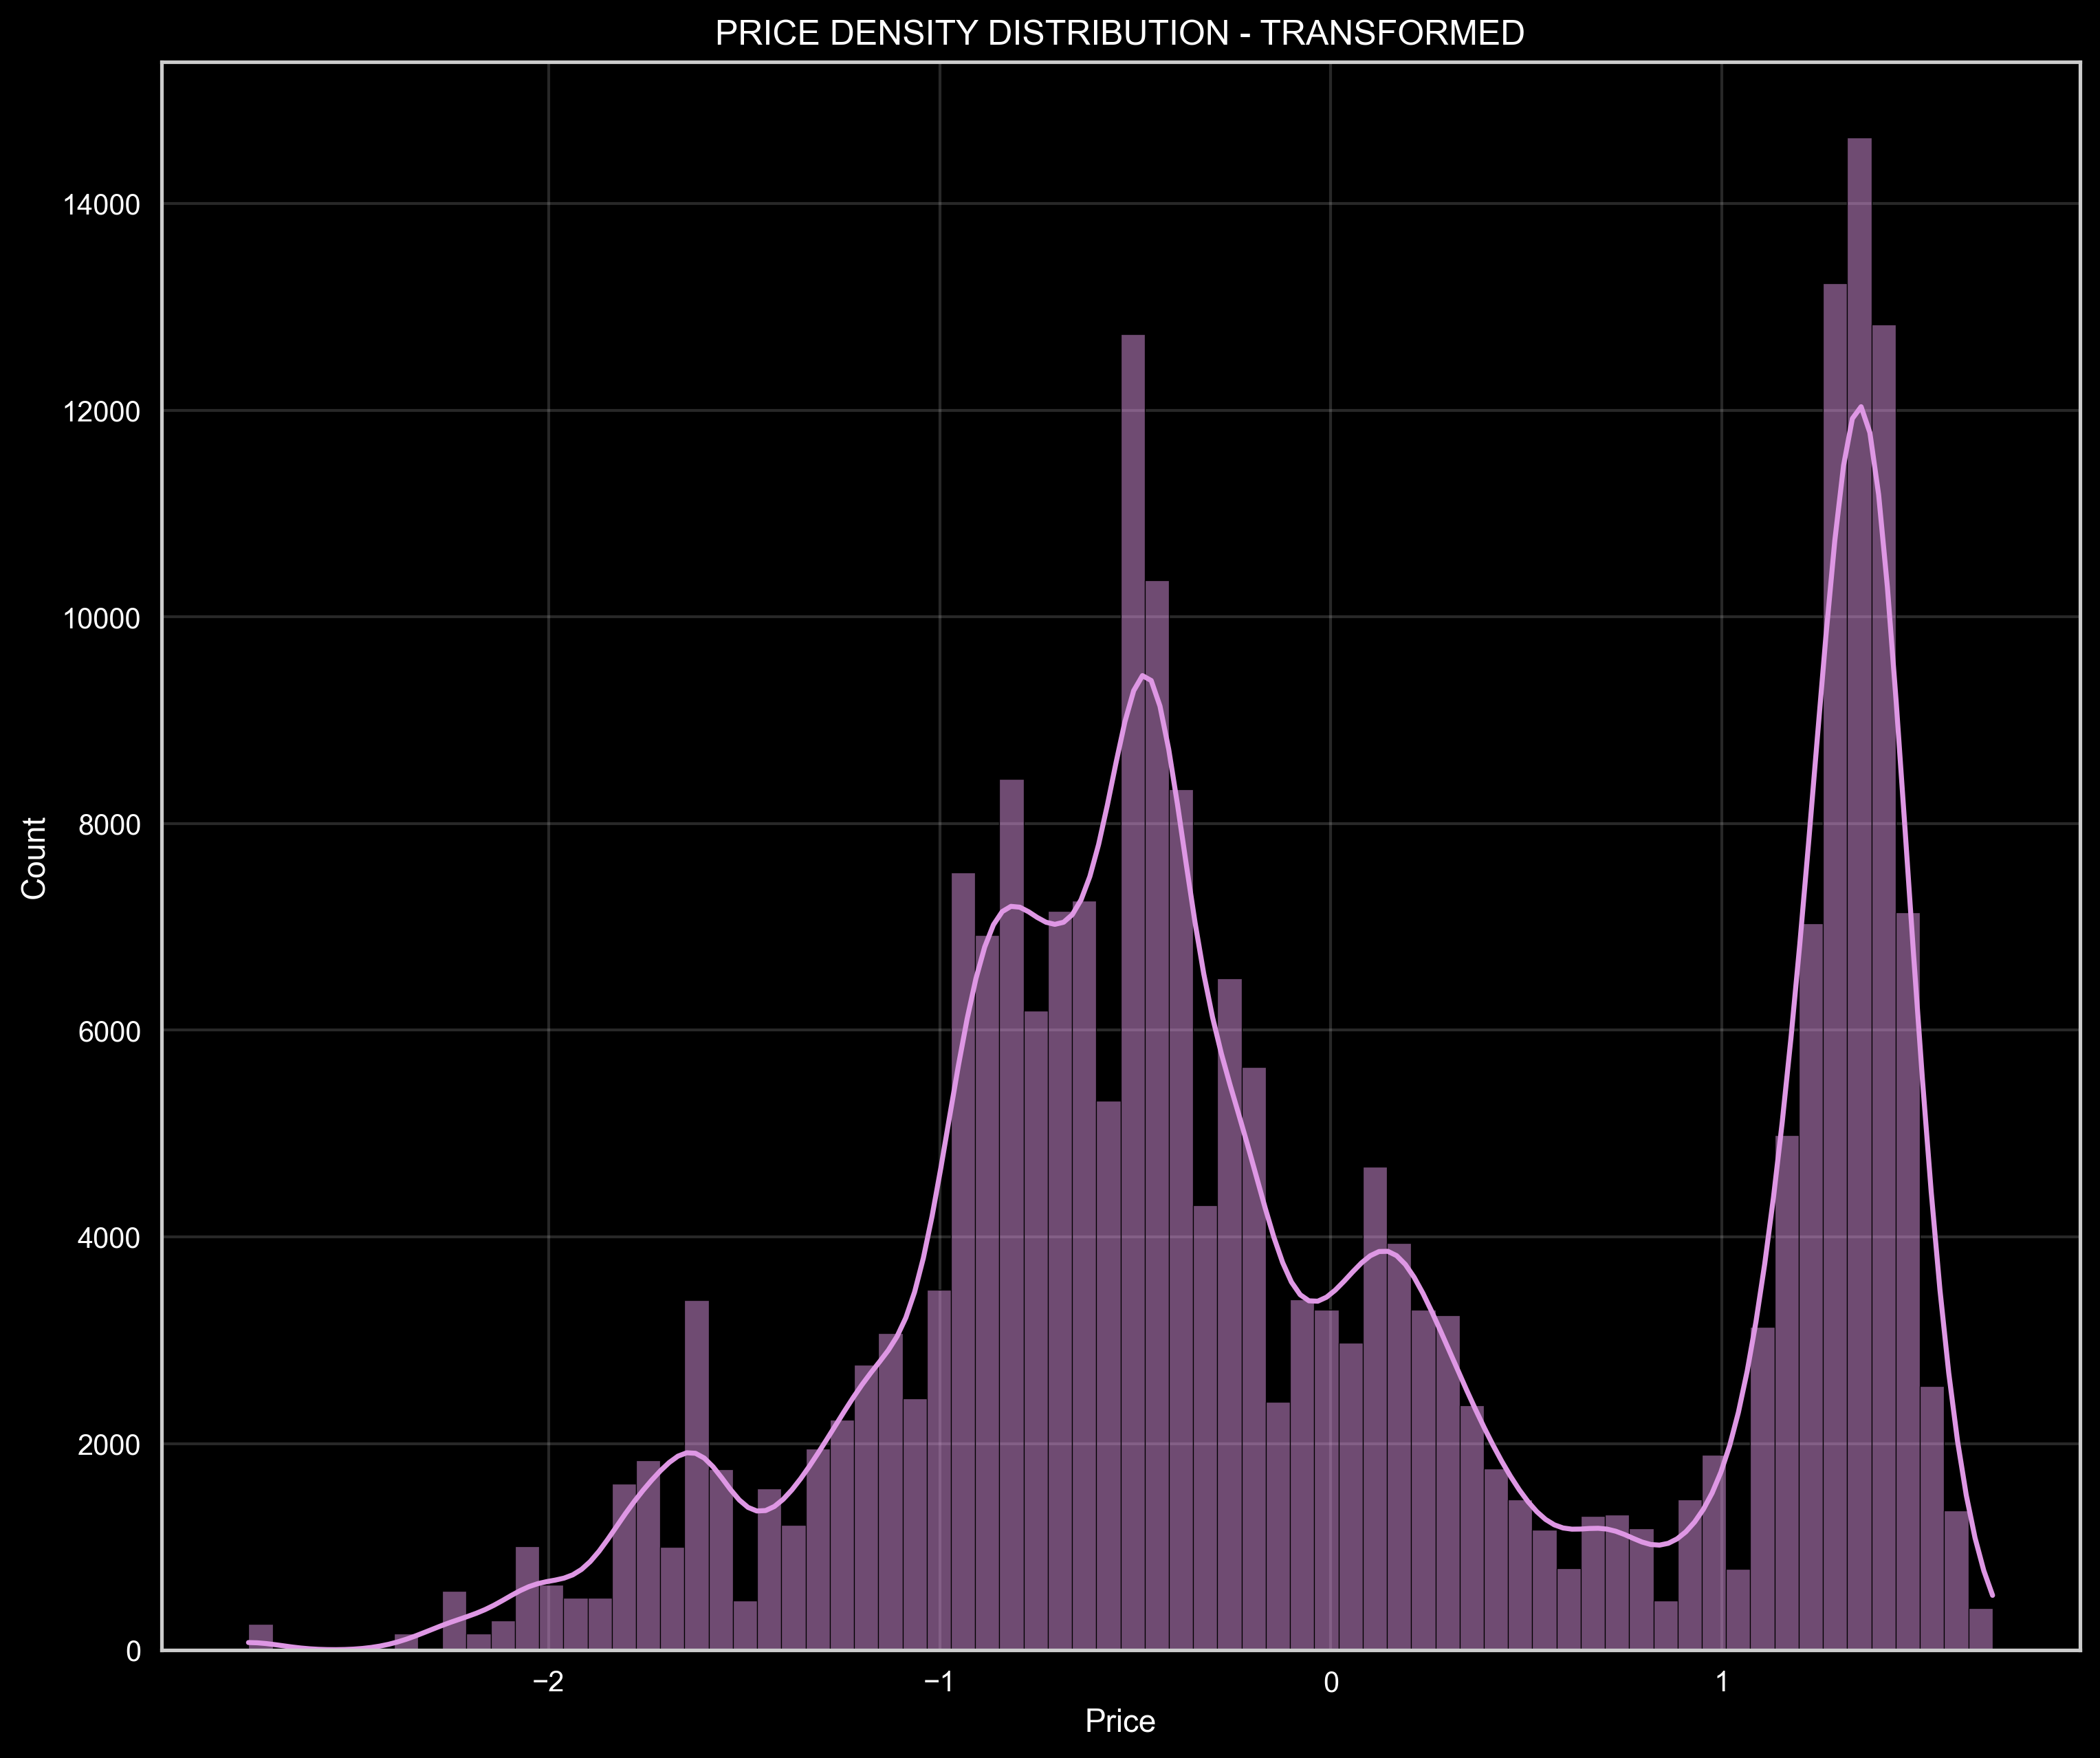

In [21]:
ytrbc = pd.DataFrame(y_train, columns=['ytrain_boxcox'])

fig, axs = plt.subplots(figsize=(12,10), dpi=300)
sns.histplot(data=ytrbc, x='ytrain_boxcox', kde=True, color=(222/255, 151/255, 228/255))
axs.set_facecolor((0,0,0))
plt.title('PRICE DENSITY DISTRIBUTION - TRANSFORMED', color='white')
plt.xlabel('Price', color='white')
plt.ylabel('Count', color='white')
plt.tick_params(colors='white')
plt.grid(alpha=0.2)
fig.patch.set_facecolor((0, 0, 0))
plt.show()

In [22]:
ct = ColumnTransformer([
    ('hot', OneHotEncoder(drop='first', sparse_output=False), ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class']), 
    ('ord', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]), ['stops']),
    ('pow', PowerTransformer(method='yeo-johnson'), ['duration']),
    ('std', StandardScaler(), ['days_left']),
    ('drop', 'drop', ['flight'])
], remainder='passthrough') #passthrough is not useful this time, I'm just used to use it and I think it's good practice
ct
#30 features in output

ColumnTransformer(remainder='passthrough',
                  transformers=[('hot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['airline', 'source_city', 'departure_time',
                                  'arrival_time', 'destination_city',
                                  'class']),
                                ('ord',
                                 OrdinalEncoder(categories=[['zero', 'one',
                                                             'two_or_more']]),
                                 ['stops']),
                                ('pow', PowerTransformer(), ['duration']),
                                ('std', StandardScaler(), ['days_left']),
                                ('drop', 'drop', ['flight'])])

In [23]:
loo_pipe = Pipeline([
    ('loo', LeaveOneOutEncoder()),
    ('std', StandardScaler())
])

ctl = ColumnTransformer([
    ('loo', loo_pipe, ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class']), 
    ('ord', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]), ['stops']),
    ('pow', PowerTransformer(method='yeo-johnson'), ['duration']),
    ('std', StandardScaler(), ['days_left']),
    ('drop', 'drop', ['flight'])
], remainder='passthrough') #passthrough is not useful this time, I'm just used to use it and I think it's good practice
ctl
#10 features in output

ColumnTransformer(remainder='passthrough',
                  transformers=[('loo',
                                 Pipeline(steps=[('loo', LeaveOneOutEncoder()),
                                                 ('std', StandardScaler())]),
                                 ['airline', 'source_city', 'departure_time',
                                  'arrival_time', 'destination_city',
                                  'class']),
                                ('ord',
                                 OrdinalEncoder(categories=[['zero', 'one',
                                                             'two_or_more']]),
                                 ['stops']),
                                ('pow', PowerTransformer(), ['duration']),
                                ('std', StandardScaler(), ['days_left']),
                                ('drop', 'drop', ['flight'])])

In [78]:
#class CyclicEncoder(BaseEstimator, TransformerMixin):
#    """
#    Encode a cyclic feature
#    """
#
#    def __init__(self, column, max_val):
#        self.column = column
#        self.max_val = max_val
#
#    def fit(self, X, y=None):
#        return self
#
#    def transform(self, X):
#        X_ = X.copy()
#        X_[self.column + '_sin'] = np.sin(2 * np.pi * X_[self.column]/self.max_val)
#        X_[self.column + '_cos'] = np.cos(2 * np.pi * X_[self.column]/self.max_val)
#        X_ = X_.drop(columns=self.column)
#        return X_
#
#
#cyclical_features = [
#    ('departure_time', X_train.departure_time.nunique()),
#    ('arrival_time', X_train.arrival_time.nunique())
#]
#
#cyclical_transformer = Pipeline(steps=[
#    ('cyclical', CyclicEncoder(column, max_val))
#    for column, max_val in cyclical_features
#])
#cyclical_transformer
#
##departure_time and arrival_time have the same values
##so we can create a unique pipeline
#np.unique(X_train.departure_time) == np.unique(X_train.arrival_time)
#
#cyc_pipe = Pipeline([
#    ('ord_dep', OrdinalEncoder(categories=[['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']])),
#    ('cyc_int',cyclical_transformer)
#])
#cyc_pipe
#
#ctc = ColumnTransformer([
#    ('cyc', cyc_pipe, [column for column, _ in cyclical_features]),
#    ('hot', OneHotEncoder(drop='first', sparse_output=False), ['airline', 'source_city', 'destination_city', 'class']), 
#    ('ord', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]), ['stops']),
#    ('pow', PowerTransformer(method='yeo-johnson'), ['duration']),
#    ('std', StandardScaler(), ['days_left']),
#    ('drop', 'drop', ['flight'])
#], remainder='passthrough') #passthrough is not useful this time, I'm just used to use it and I think it's good practice
#ctc

In [108]:
##questo funziona perfettamente
##ma non ha il get_features_names_out
#class CyclicEncoder(BaseEstimator, TransformerMixin):
#    """
#    Encode a cyclic feature
#    """
#
#    def __init__(self, max_val):
#        self.max_val = max_val
#
#    def fit(self, X, y=None):
#        return self
#
#    def transform(self, X):
#        X_ = np.empty((len(X), 2))
#        X_[:, 0] = np.sin(2 * np.pi * X[:, 0] / self.max_val)
#        X_[:, 1] = np.cos(2 * np.pi * X[:, 0] / self.max_val)
#        return X_

In [112]:
class CyclicEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclic feature
    """

    def __init__(self, max_val):
        self.max_val = max_val

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = np.empty((len(X), 2))
        X_[:, 0] = np.sin(2 * np.pi * X[:, 0] / self.max_val)
        X_[:, 1] = np.cos(2 * np.pi * X[:, 0] / self.max_val)
        return X_
    
    def get_feature_names_out(self, input_features=None):
        # Check that input_features contains only one feature
        if len(input_features) != 1:
            raise ValueError("Input array should have exactly one column.")
        
        feature = input_features[0]
        return np.array([f'{feature}_sin', f'{feature}_cos'])

In [113]:
cyclical_features = [
    ('departure_time', X_train.departure_time.nunique()),
    ('arrival_time', X_train.arrival_time.nunique())
]

In [114]:
cyclical_transformers = [
    (f"cyclical_{column}", 
     Pipeline(steps=[
         ('ordinal', OrdinalEncoder(categories=[['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']])), 
         ('cyclical', CyclicEncoder(max_val))
     ]), 
     [column])
    for column, max_val in cyclical_features
]
#cyclical_transformers

In [115]:
ctc = ColumnTransformer([
    ('hot', OneHotEncoder(drop='first', sparse_output=False), ['airline', 'source_city', 'destination_city', 'class']), 
    ('ord', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]), ['stops']),
    ('pow', PowerTransformer(method='yeo-johnson'), ['duration']),
    ('std', StandardScaler(), ['days_left']),
    ('drop', 'drop', ['flight'])
] + cyclical_transformers,
    remainder='passthrough') #passthrough is not useful this time, I'm just used to use it and I think it's good practice
ctc

ColumnTransformer(remainder='passthrough',
                  transformers=[('hot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['airline', 'source_city', 'destination_city',
                                  'class']),
                                ('ord',
                                 OrdinalEncoder(categories=[['zero', 'one',
                                                             'two_or_more']]),
                                 ['stops']),
                                ('pow', PowerTransformer(), ['duration']),
                                ('std', StandardScaler(), ['days_left']),
                                ('drop', 'drop', ['flight']),
                                ('c...
                                                  OrdinalEncoder(categories=[['Early_Morning',
                                                                              'Morning',
                                                                              'Afternoon',
                                                                              'Evening',
                                                                              'Night',
                                                                              'Late_Night']])),
                                                 ('cyclical',
                                                  CyclicEncoder(max_val=6))]),
                                 ['departure_time']),
                                ('cyclical_arrival_time',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['Early_Morning',
                                                                              'Morning',
                                                                              'Afternoon',
                                                                              'Evening',
                                                                              'Night',
                                                                              'Late_Night']])),
                                                 ('cyclical',
                                                  CyclicEncoder(max_val=6))]),
                                 ['arrival_time'])])

In [ ]:
########
########

### CORRELATION AFTER PRE-PROCESSING

In [ ]:
df_corr = ct.fit_transform(df.iloc[:,:-1])
df_corr = pd.DataFrame(df_corr, columns=ct.get_feature_names_out())

we declare another power transformer, because if we use the same we use on y_train we would then obtain wrong predictions with the inverse_transform method

In [ ]:
power_corr = PowerTransformer() 
y_corr = power_corr.fit_transform(np.array(df.iloc[:,-1]).reshape(-1,1))
y_corr = pd.DataFrame(y_corr, columns=['price'])

In [ ]:
df_corr = pd.concat([df_corr, y_corr], axis=1)

In [ ]:
#sns.heatmap(df_corr.corr(), cmap='coolwarm')

In [ ]:
sns.set(font_scale=0.7)
plt.subplots(figsize=(25,5), dpi=300)
sns.heatmap(pd.DataFrame(df_corr.corrwith(df_corr['price']), columns=['price']).T, annot=True, cmap='coolwarm', square=True)
plt.title('PRICE CORRELATION - PREPROCESSED DATA')

In [ ]:
import matplotlib.colors as mcolors
my_style = {
    'xtick.bottom': True,
    'ytick.left': True,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.edgecolor': 'white',
    'text.color': mcolors.to_hex((222/255, 151/255, 228/255)),
    'xtick.color': mcolors.to_hex((222/255, 151/255, 228/255)),
    'ytick.color': mcolors.to_hex((222/255, 151/255, 228/255)),
    'axes.facecolor': 'black',
    'axes.labelcolor': mcolors.to_hex((222/255, 151/255, 228/255))
}

fig, ax = plt.subplots(figsize=(25,5), dpi=300)
sns.set_style(style=my_style)
#sns.set(font_scale=0.7)

#ax.set_facecolor((0,0,0))
sns.heatmap(pd.DataFrame(df_corr.corrwith(df_corr['price']), columns=['price']).T, annot=True, cmap='coolwarm', square=True)
plt.title('PRICE CORRELATION - PREPROCESSED DATA')
fig.patch.set_facecolor((0, 0, 0))
plt.show()

### MUTUAL INFO REGRESSION

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
df_corr = ct.fit_transform(df.iloc[:,:-1])
df_corr = pd.DataFrame(df_corr, columns=ct.get_feature_names_out())

#we declare another power transformer, because if we use the same we use on y_train we would then obtain wrong predictions with the inverse_transform method
power_corr = PowerTransformer() 
y_corr = power_corr.fit_transform(np.array(df.iloc[:,-1]).reshape(-1,1))
y_corr = pd.DataFrame(y_corr, columns=['price'])

In [ ]:
mi = mutual_info_regression(df_corr, y_corr)
mi = pd.DataFrame(mi, columns=['price'], index=df_corr.columns)

In [ ]:
#import matplotlib.colors as mcolors
#my_style = {
#    'xtick.bottom': True,
#    'ytick.left': True,
#    'xtick.labelsize': 12,
#    'ytick.labelsize': 12,
#    'axes.edgecolor': 'white',
#    'text.color': mcolors.to_hex((222/255, 151/255, 228/255)),
#    'xtick.color': mcolors.to_hex((222/255, 151/255, 228/255)),
#    'ytick.color': mcolors.to_hex((222/255, 151/255, 228/255)),
#    'axes.facecolor': 'black',
#    'axes.labelcolor': mcolors.to_hex((222/255, 151/255, 228/255))
#}

fig, ax = plt.subplots(figsize=(25,5), dpi=300)
sns.set_style(style=my_style)
#sns.set(font_scale=0.7)

#ax.set_facecolor((0,0,0))
sns.heatmap(mi.T, annot=True, cmap='coolwarm', square=True)
plt.title('PRICE MUTUAL INFO REGRESSION - PREPROCESSED DATA')
fig.patch.set_facecolor((0, 0, 0))
plt.show()

In [ ]:
########
########

# MODEL 1 - LINEAR MODEL

## LINEAR REGRESSION

In [ ]:
#from sklearn.feature_selection import RFECV

In [ ]:
model = LinearRegression()
#rfecv = RFECV(estimator=model, cv=3)
kbest = SelectKBest(score_func=mutual_info_regression)
poly = PolynomialFeatures()
pipe = Pipeline([
    ('column_transformer', ct),
    #('selection', rfecv),
    ('selection', kbest),
    ('polynomial', poly),
    ('regressor', model)
])
pipe

In [ ]:
param_grid = {
    #'selection__min_features_to_select': [30, 20, 10],
    'selection__k': [30, 20, 10],
    'polynomial__degree': [1, 2, 3],
    'regressor__fit_intercept': [True]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train.ravel())
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

In [ ]:
model_grid.best_params_

In [ ]:
model = model_grid.best_estimator_
dump(model, 'flights_linear_poly.pkl')
dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('ADABOOST - PREDICTIONS')

In [ ]:
########

lets try with leave one out instead of one hot encoder

In [ ]:
model = LinearRegression()
#rfecv = RFECV(estimator=model, cv=3)
kbest = SelectKBest(score_func=mutual_info_regression)
poly = PolynomialFeatures()
pipel = Pipeline([
    ('column_transformer', ctl),
    #('selection', rfecv),
    ('selection', kbest),
    ('polynomial', poly),
    ('regressor', model)
])
pipel

In [ ]:
param_grid = {
    #'selection__min_features_to_select': [10, 8, 5],
    'selection__k': [10, 8, 5, 3, 1],
    'polynomial__degree': [1, 2, 3],
    'regressor__fit_intercept': [True]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV(
    estimator=pipel,
    param_grid=param_grid,
    cv=3,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    #n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train)
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

In [ ]:
model_grid.best_params_

In [ ]:
model = model_grid.best_estimator_
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('ADABOOST - PREDICTIONS')

In [ ]:
#########
#########

## SVR
for the SVR, but also for the tree based methods, we will just use the one-hot pipe, not also the loo pipe

SVR is too slow on a df of this scale, so we don't even bother to run it

In [ ]:
model = SVR()
kbest = SelectKBest(score_func=mutual_info_regression)
poly = PolynomialFeatures()
pipe = Pipeline([
    ('column_transformer', ct),
    #('selection', kbest),
    #('polynomial', poly),
    ('regressor', model)
])
pipe

In [ ]:
#valutare di fare la random grid search, che 2025 non sono pochissimissimi
param_grid = {
    #'selection__k': [30, 20, 10],
    #'polynomial__degree': [1, 2, 3],
    'regressor__kernel': ['linear', 'rbf', 'sigmoid'],
    'regressor__gamma': ['scale', 'auto', 0.1, 1, 10],
    'regressor__C': [0.1, 1, 10, 100, 1000]#,
    #'regressor__epsilon': [0.01, 0.1, 1]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    #n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train.ravel())
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

In [ ]:
model_grid.best_params_

In [ ]:
model = model_grid.best_estimator_
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('SVR - PREDICTIONS')

In [ ]:
##########
##########

## SGD REGRESSOR

In [ ]:
model = SGDRegressor()
#kbest = SelectKBest(score_func=mutual_info_regression)
poly = PolynomialFeatures()
pipe = Pipeline([
    ('column_transformer', ct),
    #('selection', kbest),
    ('polynomial', poly),
    ('regressor', model)
])
pipe

In [ ]:
#pipe.fit(X_train, y_train)
#
#model=pipe
#metrics()

#visualizer()

In [ ]:
#valutare di fare la random grid search, che 2025 non sono pochissimissimi
param_grid = {
    #'selection__k': [30, 20, 10],
    'polynomial__degree': [1, 2], #, 3
    'regressor__loss': ['squared_error', 'squared_epsilon_insensitive'], #, 'huber', 'epsilon_insensitive'
    'regressor__penalty': ['l2', 'l1', 'elasticnet', None], 
    'regressor__learning_rate': ['optimal', 'adaptive'], #'constant', 'invscaling',
    'regressor__max_iter': [10000]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV( #RandomizedSearchCV #GridSearchCV
    estimator=pipe,
    param_grid=param_grid,
    #param_distributions=param_grid,
    #n_iter=10,
    cv=3,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train.ravel())
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

In [ ]:
model_grid.best_params_

In [ ]:
model = model_grid.best_estimator_
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
##n kerniel dies while plotting the second graph
#visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('ADABOOST - PREDICTIONS')

In [ ]:
#########
#########

# MODEL 2 - ENSAMBLE MODELS

## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train.ravel())

In [ ]:
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('RANDOM FOREST - PREDICTIONS')

In [ ]:
#########
#########

## HIST GRADIENT BOOSTING

In [90]:
from sklearn.ensemble import HistGradientBoostingRegressor

### NO TUNE TRY

In [116]:
X_train_ct = ctc.fit_transform(X_train)
X_test_ct = ctc.transform(X_test)

In [117]:
#weights = []
#minimo = -2.7 #min(y_train)
#for i in y_train:
#    if i == minimo:
#        weights.append(2)
#    else:
#        weights.append(1)

In [118]:
model = HistGradientBoostingRegressor()
model.fit(X_train_ct, y_train.ravel()) #,  sample_weight=weights

HistGradientBoostingRegressor()

In [119]:
#dump(model, 'hist_regressor.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics_ct()

R2:
train 0.9543238773754231
test: 0.9548635746325111


RMSE
train 0.2137197291421101
test: 0.21247662932596698


MAPE:
train 1.2068365521602942
test: 1.2934677763559332




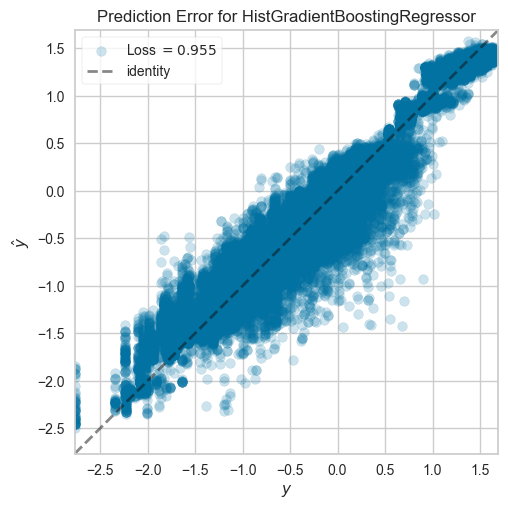

In [120]:
visualizer_ct()

In [105]:
#preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
#sns.histplot(data=preds, x='y_pred', kde=True)
#plt.title('HIST GRADIENT BOOSTING - PREDICTIONS')

In [106]:
#########
#########

### FEATURE SELECTION - SHAP

we arleady knwew about shap and what it does, but we've taken code from chat gpt to actually use it

In [129]:
shap.initjs()

feature_names = ctc.get_feature_names_out()

explainer = shap.Explainer(model)
shap_values = explainer(X_test_ct) #capire se si deve usare X_train o X_test

# Get the absolute SHAP values for each feature
abs_shap_values = np.abs(shap_values.values).mean(0)

# Sort the features by average absolute SHAP value
importance_order = np.argsort(abs_shap_values)[::-1]

X_train_ct = pd.DataFrame(X_test_ct, columns=feature_names) #capire se si deve usare X_train o X_test

# Print the feature importance ranking
print("Feature importance ranking:")
for i in importance_order:
    print(X_train_ct.columns[i], abs_shap_values[i])

Feature importance ranking:
hot__class_Economy 0.787006481960691
std__days_left 0.21008899845255152
pow__duration 0.12028385074729282
hot__airline_Vistara 0.11782499117484241
hot__airline_Air_India 0.06189269323781106
hot__source_city_Kolkata 0.03524056818441873
hot__destination_city_Kolkata 0.027796672752002233
hot__airline_GO_FIRST 0.027558069396832016
hot__airline_Indigo 0.025491882255181342
cyclical_arrival_time__arrival_time_cos 0.017881522111333325
ord__stops 0.0154270368265017
hot__destination_city_Hyderabad 0.013694986450957994
hot__airline_SpiceJet 0.013123866567223075
hot__source_city_Hyderabad 0.010314623235508486
hot__source_city_Chennai 0.008336179173257475
hot__destination_city_Chennai 0.007678413603089852
cyclical_departure_time__departure_time_sin 0.0066185169254130505
hot__source_city_Mumbai 0.006402179375344277
cyclical_departure_time__departure_time_cos 0.004585026229051882
hot__destination_city_Delhi 0.004513342482618968
hot__source_city_Delhi 0.004499636954471263
h

In this chart, the x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. We can get the general sense of features’ directionality impact based on the distribution of the red and blue dots.

https://m.mage.ai/how-to-interpret-and-explain-your-machine-learning-models-using-shap-values-471c2635b78e

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


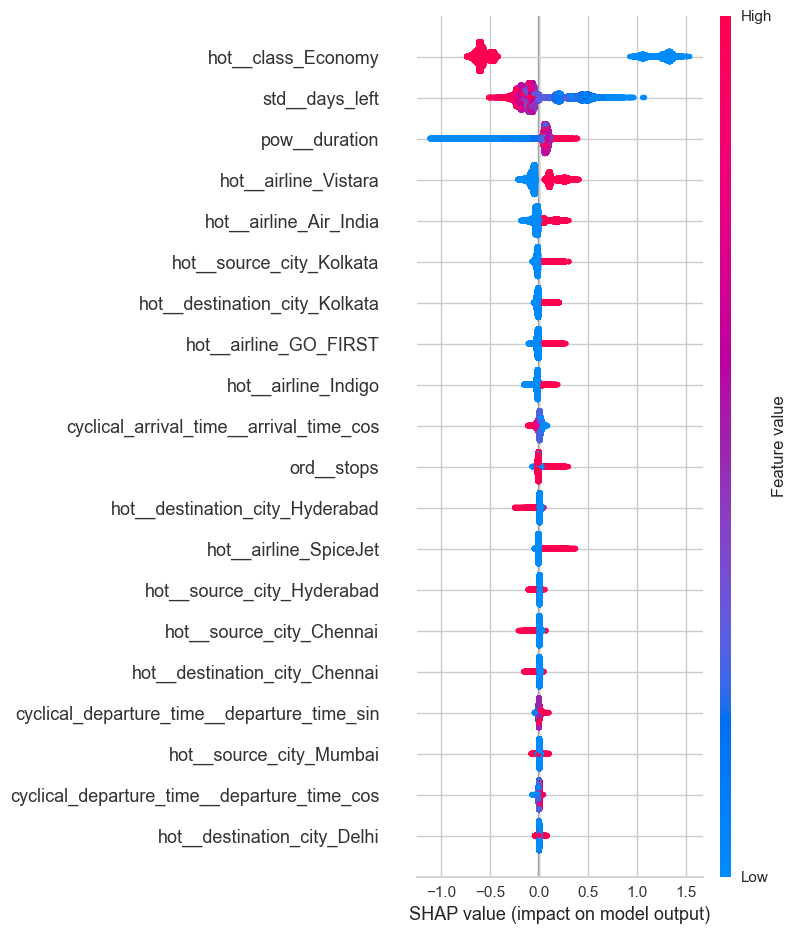

In [130]:
shap.summary_plot(shap_values, X_train_ct)

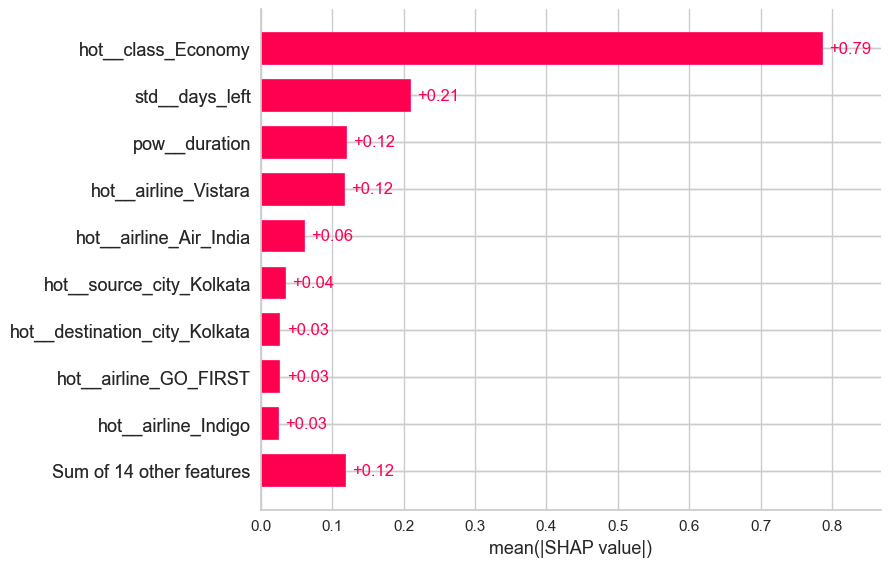

In [135]:
shap_values.feature_names = feature_names
shap.plots.bar(shap_values)

features pushing the prediction higher are shown in red ..., those pushing the prediction lower are in blue...

https://datascience.stackexchange.com/questions/65502/how-to-interpret-shapley-force-plot-for-feature-importance

In [137]:
#this refers to the first row of x_train_ct
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_train_ct.iloc[0,:])

In [125]:
X_train_ct.columns

Index(['hot__airline_Air_India', 'hot__airline_GO_FIRST',
       'hot__airline_Indigo', 'hot__airline_SpiceJet', 'hot__airline_Vistara',
       'hot__source_city_Chennai', 'hot__source_city_Delhi',
       'hot__source_city_Hyderabad', 'hot__source_city_Kolkata',
       'hot__source_city_Mumbai', 'hot__destination_city_Chennai',
       'hot__destination_city_Delhi', 'hot__destination_city_Hyderabad',
       'hot__destination_city_Kolkata', 'hot__destination_city_Mumbai',
       'hot__class_Economy', 'ord__stops', 'pow__duration', 'std__days_left',
       'cyclical_departure_time__departure_time_sin',
       'cyclical_departure_time__departure_time_cos',
       'cyclical_arrival_time__arrival_time_sin',
       'cyclical_arrival_time__arrival_time_cos'],
      dtype='object')

In [ ]:
##########
##########

### TUNING

In [ ]:
model = HistGradientBoostingRegressor()
kbest = SelectKBest(score_func=mutual_info_regression)
poly = PolynomialFeatures()
pipe = Pipeline([
    ('column_transformer', ct),
    #('selection', kbest),
    #('polynomial', poly),
    ('regressor', model)
])
pipe

In [ ]:
#valutare di fare la random grid search, che 2025 non sono pochissimissimi
param_grid = {
    #'selection__k': [30, 20, 10],
    #'polynomial__degree': [1, 2, 3],
    'regressor__loss': ['squared_error', 'absolute_error'],
    'regressor__learning_rate': [0.1, 0.5, 1],
    'regressor__max_iter': [10000, 100000], #
    'regressor__max_leaf_nodes': [2020], #2020 = int(np.unique(y_train).sum())
    'regressor__max_depth': [None],
    'regressor__min_samples_leaf': [1],
    'regressor__l2_regularization':[0, 0.5, 1]
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    n_jobs=-1, #usa tutti i kernel 
    pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train.ravel())
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

In [ ]:
model_grid.best_params_

In [ ]:
model = model_grid.best_estimator_
#dump(model, 'flights_histgbr.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('HIST GRADIENT BOOSTING REGRESSOR - PREDICTIONS')

In [ ]:
##########
##########

In [ ]:
##########
##########

## GRADIENT DESCEND BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train.ravel())

In [ ]:
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('GRADIENT DESCEND BOOSTING - PREDICTIONS')

In [ ]:
#########
#########

## ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
model = AdaBoostRegressor()
model.fit(X_train, y_train.ravel())

In [ ]:
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('ADABOOST - PREDICTIONS')

In [ ]:
#########
#########

## XGBOOST

In [ ]:
from xgboost import XGBRegressor

### NO TUNE TRY

In [ ]:
X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

In [ ]:
model = XGBRegressor()
model.fit(X_train_ct, y_train.ravel())

In [ ]:
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics_ct()

In [ ]:
visualizer_ct()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('ADABOOST - PREDICTIONS')

In [ ]:
##########
##########

### TUNING

In [ ]:
model = XGBRegressor()
#kbest = SelectKBest(score_func=mutual_info_regression)
#poly = PolynomialFeatures()
pipe = Pipeline([
    ('column_transformer', ct),
    #('selection', kbest),
    #('polynomial', poly),
    ('regressor', model)
])
pipe

In [ ]:
X_train.shape[0]/18

In [ ]:
#valutare di fare la random grid search, che 2025 non sono pochissimissimi
param_grid = {
    #'selection__k': [30, 20, 10],
    #'polynomial__degree': [1, 2], #, 3
    'regressor__max_depth': [1, 2, 6],
    'regressor__penalty': [1, 1000, 13335], #13335 = X_train.shape[0]/18 (18 is the number of bins for stratified train-test split)
    'regressor__eta': [0, 0.5, 1],
    'regressor__gamma': [0, 10, 1000],
    'regressor__max_delta_step': [0, 10, 1000],
    'regressor__subsample': [0.5, 1],
    #'regressor__sampling_method'
    'regressor__tree_method': ['hist'],
    'regressor__process_type': ['default'],
    'regressor__grow_policy': ['depthwise', 'lossguide'],
    'regressor__predictor': ['cpu_predictor'],
    'regressor__num_parallel_tree': [1, 2, 10],
    
}

adesso = datetime.datetime.now()
###
#scoring = ['accuracy','recall']
grid = RandomizedSearchCV( #RandomizedSearchCV #GridSearchCV
    estimator=pipe,
    #param_grid=param_grid,
    param_distributions=param_grid,
    n_iter=300,
    cv=3,
    verbose=3, #quando usiamo il parallel computer (n_jobs) il verbose non funziona
    n_jobs=-1, #usa tutti i kernel 
    #pre_dispatch=4,
    #scoring=scoring
)

model_grid = grid.fit(X_train, y_train.ravel())
###
adesso_2 = datetime.datetime.now()
tempo_elapsed = adesso_2 - adesso
tempo_elapsed

In [ ]:
model_grid.best_params_

In [ ]:
model = model_grid.best_estimator_
#usare model.save() o una roba del genere
#dump(model, 'flights_xgboost.pkl')
#dump(power, 'flights_test_power_scaler_xg.pkl')
metrics()

In [ ]:
visualizer()

In [ ]:
preds = pd.DataFrame(power.inverse_transform(y_test), columns=['y_pred'])
sns.histplot(data=preds, x='y_pred', kde=True)
plt.title('XGBOOST - PREDICTIONS')

In [ ]:
#model.save_model('flights_xgboost.json')

In [ ]:
##########
##########

## XGBOOST DMATRICES

In [ ]:
import xgboost as xgb
import patsy

### NO TUNE TRY

In [ ]:
X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

code was taken from chatgpt

In [ ]:
formula = 'label ~ feature1 + feature2 + feature3'

X_train_ct = pd.DataFrame(X_train_ct, columns=ct.get_feature_names_out())
y_train = pd.DataFrame(y_train, columns=['price'])
X_test_ct = pd.DataFrame(X_test_ct, columns=ct.get_feature_names_out())
y_test = pd.DataFrame(y_test, columns=['price'])

data_train = pd.concat([y_train, X_train_ct], axis=1)
data_test = pd.concat([y_test, X_test_ct], axis=1)

y_train, X_train_ct = patsy.dmatrices(formula, data=data_train, return_type='dataframe')
y_test, X_test_ct = patsy.dmatrices(formula, data=data, return_type='dataframe')

dtrain = xgb.DMatrix(X_train_ct, label=y_train)

In [ ]:
model = XGBRegressor()
model.fit(X_train_ct, y_train.ravel())

In [ ]:
#dump(model, '###.pkl')
#dump(power, 'flights_test_power_scaler.pkl')
metrics_ct()

In [ ]:
visualizer_ct()

# adfgdfhkgjl